In [1]:
import sys
print(sys.executable)


c:\Projects\UIDAI_Hackathon_project\venv\Scripts\python.exe


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.statistics import compute_stats_for_dataframe


In [2]:
DATA_PATH = "data/processed/enrollment/karnataka_processed.csv"

df = pd.read_csv(DATA_PATH)

df.head()


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_updates,month,month_name,log_total_updates
0,2025-09-01,Karnataka,Bagalkot,587120,4,0,0,4,9,September,1.609438
1,2025-09-01,Karnataka,Bagalkot,587122,4,1,0,5,9,September,1.791759
2,2025-09-01,Karnataka,Bagalkot,587203,8,2,0,10,9,September,2.397895
3,2025-09-01,Karnataka,Bagalkot,587205,2,0,0,2,9,September,1.098612
4,2025-09-01,Karnataka,Bagalkot,587206,6,2,0,8,9,September,2.197225


Univariate analysis

In [3]:
NUMERIC_COLUMNS = [
    "age_0_5",
    "age_5_17",
    "age_18_greater",
    "total_updates",
]


In [7]:
stats_df = compute_stats_for_dataframe(df, NUMERIC_COLUMNS)
stats_df

,mean,median,variance,std_dev,iqr,mad,skewness,excess_kurtosis,min,max,count
age_0_5,2.514267,1.0,64.939431,8.058501,2.0,1.0,30.499305,1238.834703,0.0,560.0,86772.0
age_5_17,0.551215,0.0,13.327533,3.650689,1.0,0.0,33.396176,1448.501855,0.0,263.0,86772.0
age_18_greater,0.131967,0.0,5.092045,2.256556,0.0,0.0,42.938346,2322.384702,0.0,168.0,86772.0
total_updates,3.197448,2.0,165.487918,12.864211,2.0,1.0,29.578170,1074.043497,1.0,804.0,86772.0


In [8]:
stats_df[["mean", "median", "std_dev", "iqr", "mad", "skewness", "excess_kurtosis"]]


,mean,median,std_dev,iqr,mad,skewness,excess_kurtosis
age_0_5,2.514267,1.0,8.058501,2.0,1.0,30.499305,1238.834703
age_5_17,0.551215,0.0,3.650689,1.0,0.0,33.396176,1448.501855
age_18_greater,0.131967,0.0,2.256556,0.0,0.0,42.938346,2322.384702
total_updates,3.197448,2.0,12.864211,2.0,1.0,29.578170,1074.043497


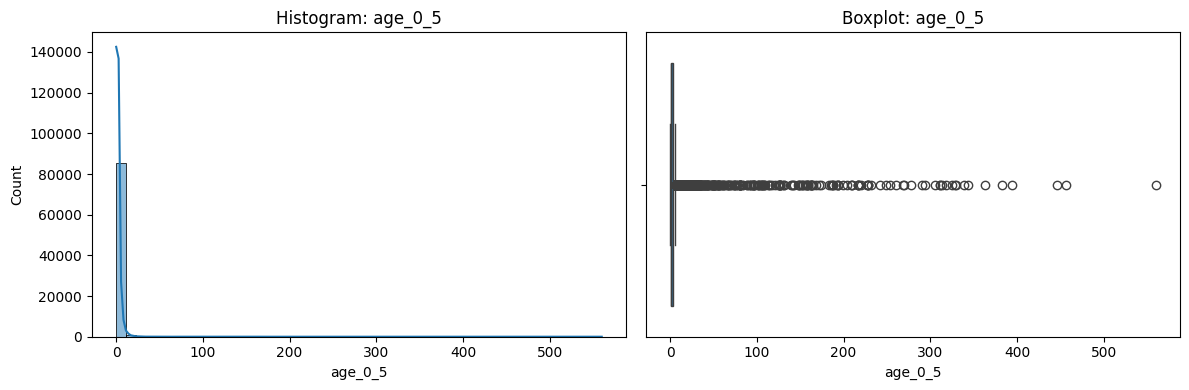

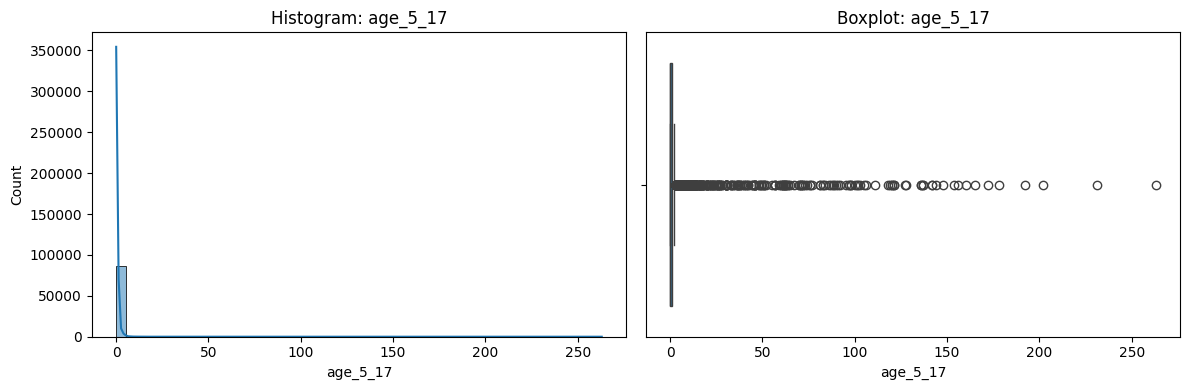

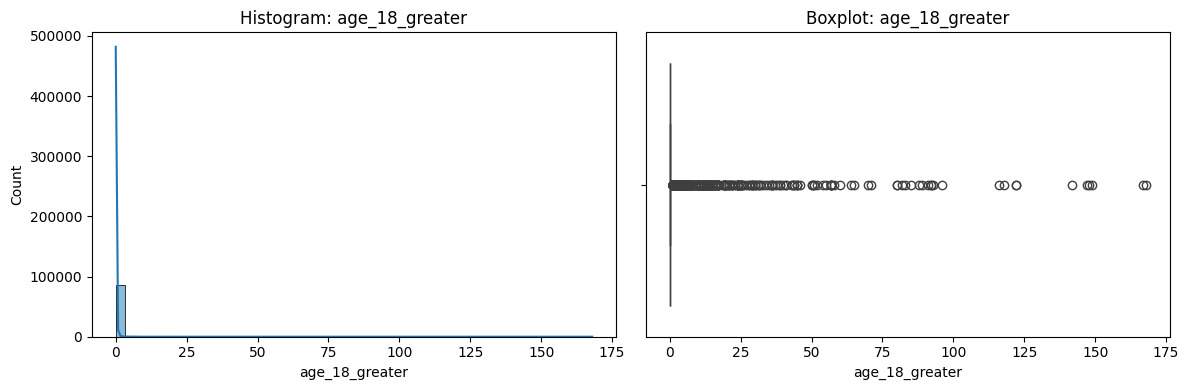

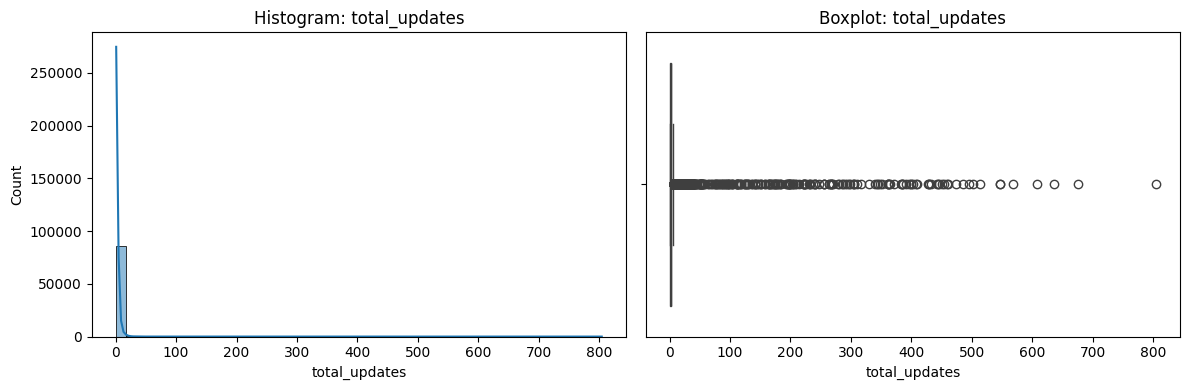

In [9]:
for col in NUMERIC_COLUMNS:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram: {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot: {col}")

    plt.tight_layout()
    plt.show()


Temporal Analysis

In [3]:
from utils.statistics import (
    perform_stl_decomposition,
    bayesian_change_point_detection
)

plt.style.use("seaborn-v0_8-darkgrid")

In [8]:
daily_ts = (
    df.groupby("date", as_index=False)["total_updates"]
    .sum()
)

daily_ts.head()


,date,total_updates
0,2025-03-09,248
1,2025-03-20,484
2,2025-04-01,9586
3,2025-05-01,5491
4,2025-06-01,11685


In [9]:
stl_df = perform_stl_decomposition(
    df=daily_ts,
    date_col="date",
    value_col="total_updates",
    period=30  # monthly seasonality
)

stl_df.head()


,date,total_updates,trend,seasonal,residual
0,2025-03-09,248,4240.795397,-3992.795396,-5.884331e-07
1,2025-03-20,484,4213.369866,-3729.369865,-4.944968e-07
2,2025-04-01,9586,4185.944334,5400.055666,-4.045078e-07
3,2025-05-01,5491,4158.518803,1332.481197,-3.184978e-07
4,2025-06-01,11685,4131.093272,7553.906728,-2.364413e-07


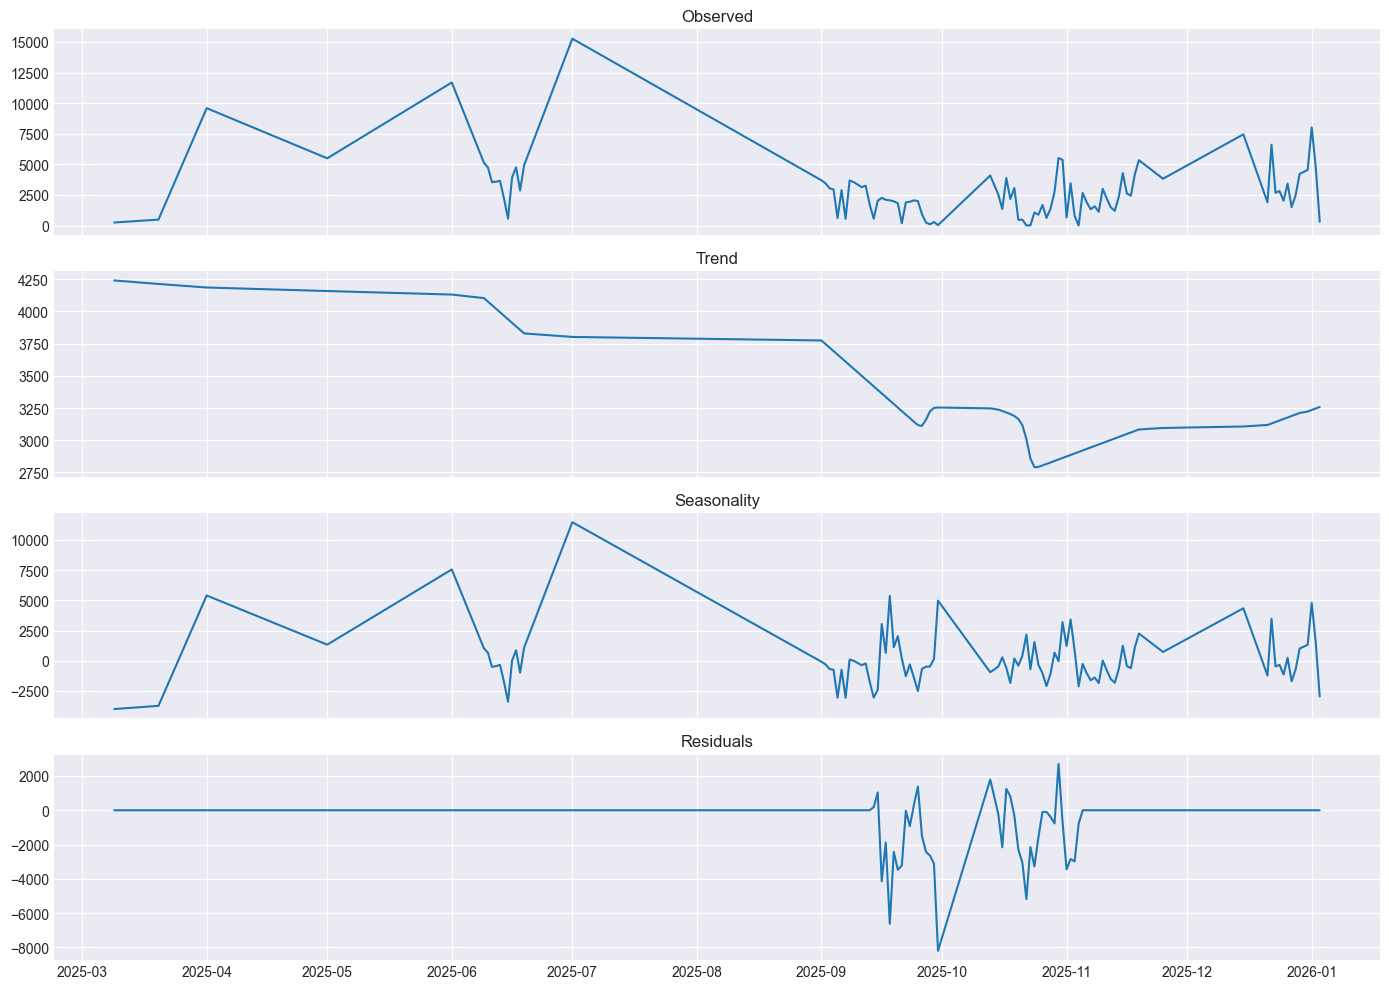

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(stl_df["date"], stl_df["total_updates"])
axes[0].set_title("Observed")

axes[1].plot(stl_df["date"], stl_df["trend"])
axes[1].set_title("Trend")

axes[2].plot(stl_df["date"], stl_df["seasonal"])
axes[2].set_title("Seasonality")

axes[3].plot(stl_df["date"], stl_df["residual"])
axes[3].set_title("Residuals")

plt.tight_layout()
plt.show()


In [11]:
bcp_df = bayesian_change_point_detection(
    series=stl_df["total_updates"],
    window=30,
    threshold=3.0
)

bcp_df.head()


,value,posterior_mean,posterior_std,z_score,change_point
0,248,NaN,NaN,NaN,False
1,484,NaN,NaN,NaN,False
2,9586,NaN,NaN,NaN,False
3,5491,NaN,NaN,NaN,False
4,11685,NaN,NaN,NaN,False


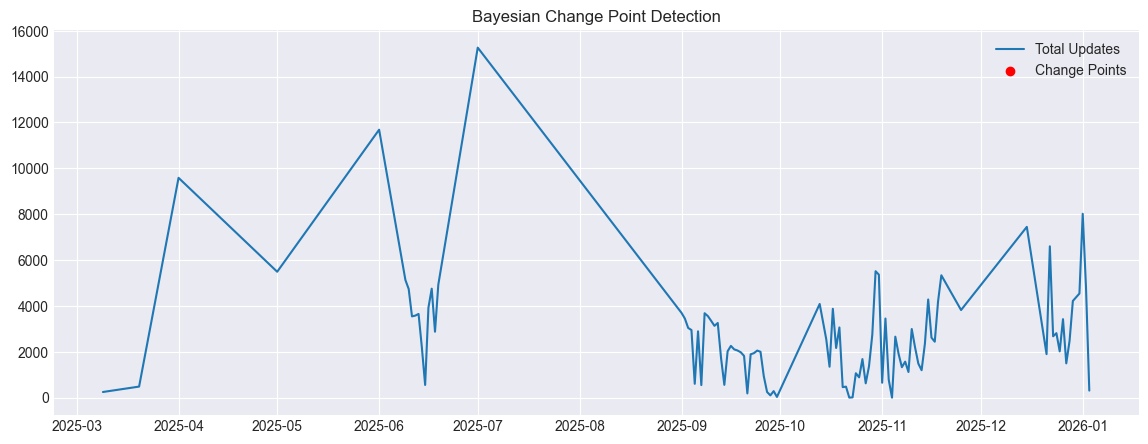

In [12]:
plt.figure(figsize=(14, 5))

plt.plot(stl_df["date"], stl_df["total_updates"], label="Total Updates")

change_points = bcp_df["change_point"]
plt.scatter(
    stl_df["date"][change_points],
    stl_df["total_updates"][change_points],
    color="red",
    label="Change Points",
    zorder=3
)

plt.legend()
plt.title("Bayesian Change Point Detection")
plt.show()


District × Month matrix

In [7]:
from utils.statistics import build_district_month_matrix

district_month = build_district_month_matrix(
    df=df,
    district_col="district",
    date_col="date",
    value_col="total_updates"
)

district_month.head()


month,2025-03,2025-04,2025-05,2025-06,2025-07,2025-09,2025-10,2025-11,2025-12,2026-01
district,,,,,,,,,,
Bagalkot,0,0,0,1487,0,2473,1293,1486,1923,567
Bagalkot *,0,0,0,33,0,85,57,56,48,18
Ballari,0,0,0,647,0,1031,503,670,598,179
Bangalore,0,0,0,1487,0,2016,1550,1964,1566,458
Bangalore Rural,0,0,240,587,0,657,495,631,645,198


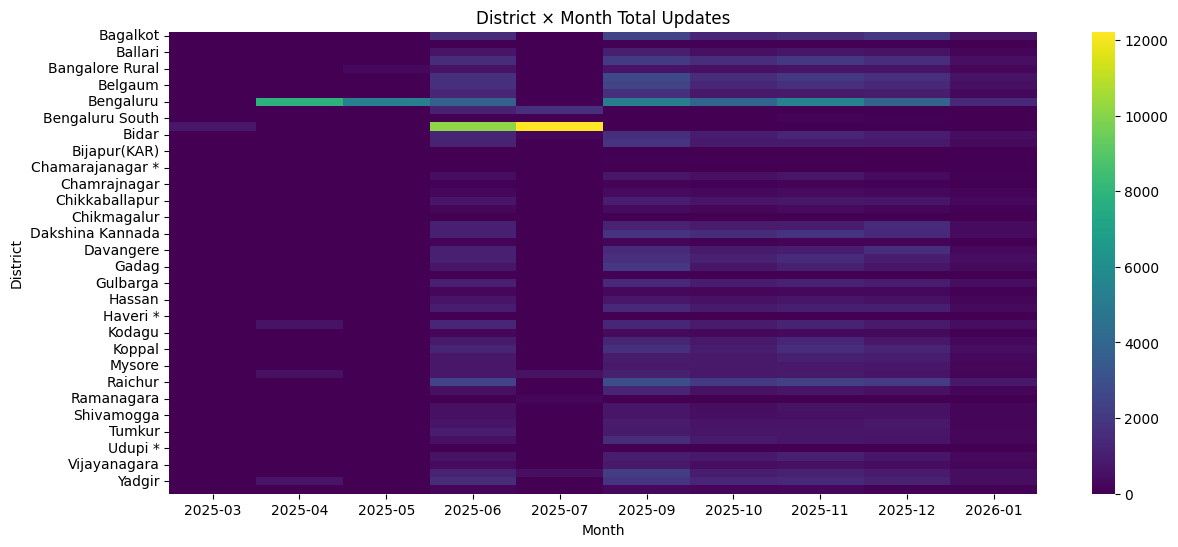

In [5]:
plt.figure(figsize=(14, 6))
sns.heatmap(district_month, cmap="viridis")
plt.title("District × Month Total Updates")
plt.xlabel("Month")
plt.ylabel("District")
plt.show()


Row Statistics (Active & Unstable Districts)

In [6]:
from utils.statistics import compute_matrix_stats

matrix_stats = compute_matrix_stats(district_month)
matrix_stats.sort_values("row_sum_total_updates", ascending=False).head()


,row_sum_total_updates,row_variance
district,,
Bengaluru,36517,6.364928e+06
Bengaluru Urban,23074,2.211933e+07
Raichur,12607,1.444475e+06
Belagavi,10177,1.027410e+06
Bagalkot,9229,8.565463e+05


Z-Score Anomalies

In [12]:
from utils.statistics import compute_zscore_anomalies

anomalies = compute_zscore_anomalies(
    district_month,
    z_thresh=2
)

anomalies[anomalies["is_anomaly"]].head()


,district,month,z_score,is_anomaly
94,Bengaluru Rural,2025-07,2.290543,True
107,Bengaluru South,2025-11,2.386658,True
114,Bengaluru Urban,2025-07,2.107452,True
285,Gadag,2025-09,2.236875,True
295,Gadag *,2025-09,2.262277,True


Outlier Scatter Plot

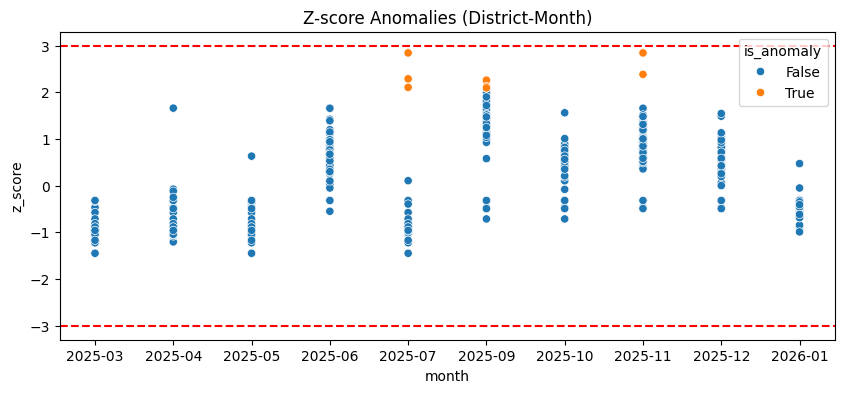

In [13]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=anomalies,
    x="month",
    y="z_score",
    hue="is_anomaly"
)
plt.axhline(3, color="red", linestyle="--")
plt.axhline(-3, color="red", linestyle="--")
plt.title("Z-score Anomalies (District-Month)")
plt.show()


In [ ]:
# Mean & std per district (row-wise)
mean = district_month.mean(axis=1)
std = district_month.std(axis=1)

#  Z-score matrix
z_scores = district_month.sub(mean, axis=0).div(std, axis=0)


In [ ]:
# Max absolute deviation per month
monthly_extremeness = z_scores.abs().max(axis=0)


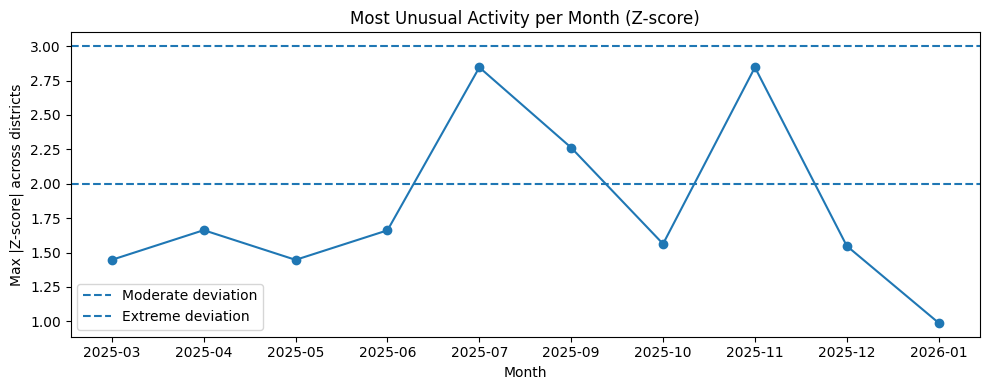

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_extremeness.index, monthly_extremeness.values, marker='o')

# Reference lines
plt.axhline(2, linestyle='--', label='Moderate deviation')
plt.axhline(3, linestyle='--', label='Extreme deviation')

plt.title("Most Unusual Activity per Month (Z-score)")
plt.xlabel("Month")
plt.ylabel("Max |Z-score| across districts")
plt.legend()
plt.tight_layout()
plt.show()


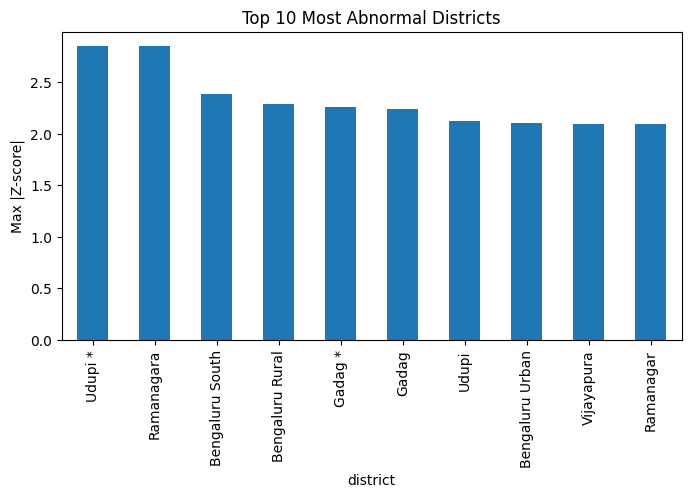

In [23]:
district_extremeness = (
    z_long
    .groupby("district")["z_score"]
    .apply(lambda x: x.abs().max())
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
district_extremeness.plot(kind="bar")
plt.ylabel("Max |Z-score|")
plt.title("Top 10 Most Abnormal Districts")
plt.show()


In [25]:
focus_month = month_extremeness.idxmax()

focus_data = (
    z_long[z_long["month"] == focus_month]
    .sort_values("z_score", key=lambda x: x.abs(), ascending=False)
    .head(10)
)


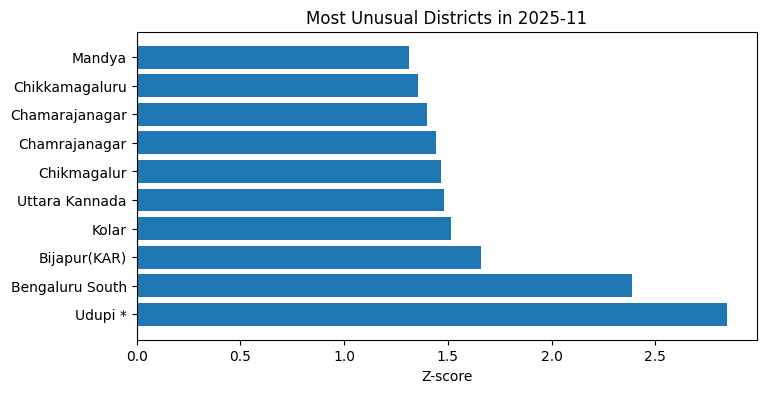

In [26]:
plt.figure(figsize=(8, 4))
plt.barh(
    focus_data["district"],
    focus_data["z_score"]
)
plt.axvline(0)
plt.title(f"Most Unusual Districts in {focus_month}")
plt.xlabel("Z-score")
plt.show()
